# Create paper emulation figure


In [1]:
import os
## Ignore my broken HDF5 install...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

In [2]:
import iris

import utils 
#import get_bc_ppe_data

#from GCEm import cnn_model, gp_model
#from GCEm.utils import get_random_params

import iris.quickplot as qplt
import iris.analysis.maths as imath
import matplotlib.pyplot as plt
%matplotlib inline

from esem import gp_model
from esem import cnn_model
from esem.utils import get_random_params


import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import xarray as xr

import numpy as np

import cartopy.crs as ccrs
from sklearn.metrics import mean_squared_error                                                      
from math import sqrt 
from datetime import datetime
import cftime


import time
import dask
import dask.array as da
from dask.distributed import Client, LocalCluster



## Read in the parameters and data
 GP model currently can only take 3 parameters  (trude)

In [14]:
#output=['FSNT','FLUT','FSDS','TGCLDLWP','CLDLOW','CLDMED','CLDHGH','CLDTOT','TS','TMQ', LWCF, SWCF]
#output=['TS','TMQ']
#output=['FSNT','FLUT']
output=['U10']
stime = '2010-01-01'
n_test_a = [3,4,5,6,7,9]

n_test_a = [21,22]
n_test_a = [49]

nmodels=174

#rangeh_arr=['3yr','5yr']
rangeh_arr=['3yr']


#typep='zm'
#typep='clubb'
#typep='aerosol'
typep='clubb'




#micro_par=['Sample_nmb', 'micro_mg_accre_enhan_fact', 'micro_mg_autocon_fact', 'micro_mg_autocon_lwp_exp', 'micro_mg_autocon_nd_exp', 'micro_mg_berg_eff_factor',
#        'micro_mg_effi_factor', 'micro_mg_homog_size']#, 'micro_mg_iaccr_factor', 'micro_mg_max_nicons']#, 'micro_mg_ncnst']

if typep == 'mp':
    micro_par=['Sample_nmb', 'micro_mg_accre_enhan_fact', 'micro_mg_autocon_fact', 'micro_mg_autocon_lwp_exp', 'micro_mg_autocon_nd_exp', 
               'micro_mg_berg_eff_factor', 'micro_mg_dcs', 'micro_mg_effi_factor', 'micro_mg_homog_size', 'micro_mg_iaccr_factor','U10']#, 
               #'micro_mg_max_nicons','micro_mg_vtrmi_factor', 'microp_aero_npccn_scale', 'microp_aero_wsub_min', 'microp_aero_wsub_scale', 
               #'microp_aero_wsubi_min', 'microp_aero_wsubi_scale']

#micro_par=['zmconv_num_cin','zmconv_momcu','zmconv_momcd','zmconv_tiedke_add','zmconv_capelmt']  

if typep =='zm': 
    micro_par=['zmconv_c0_lnd','zmconv_c0_ocn','zmconv_ke','zmconv_ke_lnd','zmconv_dmpdz','cldfrc_dp1','cldfrc_dp2','zmconv_num_cin','zmconv_momcu','zmconv_momcd','zmconv_tiedke_add','zmconv_capelmt']

if typep == 'clubb':
    micro_par=['clubb_c1','clubb_C8','clubb_c11','clubb_c14','clubb_c_K10','clubb_gamma_coef','clubb_C2rt',
               'clubb_wpxp_L_thresh','clubb_beta','clubb_C6rt','clubb_C6rtb','U10']



#parameter file
filenm = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.000/atm/hist/cc_PPE_250_ensemble_PD.000.h0.U10.nc'
nc= xr.open_dataset(filenm)
#foo=len(nc.variables)
foo=len(micro_par)
print(foo)
count=0
varname=[]
runs=(len(nc.U10))
a_list = list(range(0, runs))
print(runs)
runs=np.ndarray(runs)

# prepare parameter file in a format that can be used here
#runs_h = np.arange(len(params_all))
for var, val in nc.variables.items():
    if var in micro_par:
#        print(var)
        if count > 0:        
            paramv=nc[var]
        
            if count == 1:
                #params_all_h= np.zeros((len(paramv),len((nc.variables)-1)))
                params_all_h= np.zeros((len(paramv),foo-1))
            params_all_h[:,count-1]=paramv
            varname.append(var)
        count = count+1        

params_all_h=params_all_h[0:nmodels,:]
# #print(params_all_h)
# params_all = pd.DataFrame(params_all_h, columns = varname)       
#params_all = params_all_h       

# print(varname)


12
36


NameError: name 'params_all_h' is not defined

In [31]:
dir='/glade/campaign/cgd/projects/ppe/cam_ppe/PPE_250/control/control_timeseries/PPE_250_ensemble.'

for o in range(len(output)):
    fname=dir+'*/atm/hist/cc_PPE*h0*'+output[o]+'.nc'
    print(fname)
    #For creating coordinate "runs"
    runs_h = np.arange(len(params_all))
    print(type(runs_h))
    ppe_outh=xr.open_mfdataset(fname, concat_dim='runs',combine='nested', decode_times=False).load()
    ppe_outh.time.attrs['units']='days since 2000-01-01'

    ppe_outh = xr.decode_cf(ppe_outh)
    ppe_outh=ppe_outh.assign_coords({'runs': a_list}) 
    for r in range(len(rangeh_arr)):
        rangeh=rangeh_arr[r]
        if rangeh == '5yr':
            etime = '2005-12-31'
        if rangeh == '3yr':
            etime = '2003-12-31'
        
        ppe_out = ppe_outh.sel(time=slice(stime,etime))
        ppe_out = ppe_out.rename({'lon': 'longitude','lat': 'latitude'})

        #ppe_out = ppe_outt.sel(latitude=slice(-40,40))
        
        
        #        ppe_out=ppe_out.transpose("runs","latitude","longitude","time")

        out_var=ppe_out[output[o]]
        out_var.attrs['grid_type'] = 'rectilinear'

        
        out_var=out_var[0:nmodels,:,:,:]
        #Take annual average
        out_var=out_var.mean(dim='time')
        
#        out_var=out_var.mean(dim='latitude')
#        out_var=xr.DataArray.to_iris(out_var)   
        #out_var=out_var.mean(dim='longitude')
        for n in range(len(n_test_a)):
            n_test=n_test_a[n]
            X_test, X_train = params_all[:n_test], params_all[n_test:]
            Y_test, Y_train = out_var[:n_test], out_var[n_test:]
            Y_train=xr.DataArray.to_iris(Y_train)
            Y_test=xr.DataArray.to_iris(Y_test)   

/glade/campaign/cgd/projects/ppe/cam_ppe/PPE_250/control/control_timeseries/PPE_250_ensemble.*/atm/hist/cc_PPE*h0*LWCF.nc
<class 'numpy.ndarray'>


In [32]:
#ppe_params, ppe_aaod = get_bc_ppe_data()

In [33]:
### Ensure thWetdepnumbertime dimension is last - this is treated as the color 'channel'
### ppe_aaod.transpose((0,2,3,1))
#ppe_aaod = ppe_aaod.collapsed('time')[0]

In [34]:
#n_test = 5

#X_test, X_train = ppe_params[:n_test], ppe_params[n_test:]
#Y_test, Y_train = ppe_aaod[:n_test], ppe_aaod[n_test:]

In [35]:
Y_train

Lwcf (unknown),runs,latitude,longitude
Shape,200,192,288
Dimension coordinates,,,
runs,x,-,-
latitude,-,x,-
longitude,-,-,x


## Setup and run the models

In [36]:
gp_model_ = gp_model(X_train, Y_train, kernel=['Bias', 'Linear'])
gp_model_.train()

In [37]:
gp_prediction, _ = gp_model_.predict(X_test.values)

In [38]:
nn_model = cnn_model(X_train, Y_train)

In [39]:
nn_model.model.model.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 663552)            7299072   
_________________________________________________________________
reshape_1 (Reshape)          (None, 192, 288, 12)      0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 192, 288, 12)      2172      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 192, 288, 1)       181       
Total params: 7,301,425
Trainable params: 7,301,425
Non-trainable params: 0
_________________________________________________________________


In [40]:
nn_model.train()

Epoch 1/100
20/20 [==============================] - 25s 1s/step - loss: 0.8400 - val_loss: 1.7247
Epoch 2/100
20/20 [==============================] - 22s 1s/step - loss: 0.8211 - val_loss: 1.7900
Epoch 3/100
20/20 [==============================] - 12s 598ms/step - loss: 0.8212 - val_loss: 1.7641
Epoch 4/100
20/20 [==============================] - 12s 608ms/step - loss: 0.8196 - val_loss: 1.7659
Epoch 5/100
20/20 [==============================] - 13s 626ms/step - loss: 0.8159 - val_loss: 1.7787
Epoch 6/100
20/20 [==============================] - 12s 610ms/step - loss: 0.8187 - val_loss: 1.7680
Epoch 7/100
20/20 [==============================] - 13s 627ms/step - loss: 0.8156 - val_loss: 1.7690
Epoch 8/100
20/20 [==============================] - 12s 596ms/step - loss: 0.8143 - val_loss: 1.7809
Epoch 9/100
20/20 [==============================] - 12s 590ms/step - loss: 0.8155 - val_loss: 1.7823
Epoch 10/100
20/20 [==============================] - 12s 593ms/step - loss: 0.8148 - va

In [41]:
## Linear model:  0.3566 - val_loss: 0.0867

In [42]:
nn_prediction, _ = nn_model.predict(X_test.values)

In [43]:
#gp_model_ = gp_model(X_train, Y_train, kernel=['Bias', 'Linear'])
#gp_model_.train()

In [44]:
#gp_prediction, _ = gp_model_.predict(X_test.values)

/glade/work/trude/miniconda3/envs/climatebench/lib/python3.9/site-packages/iris/coords.py:1803: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/glade/work/trude/miniconda3/envs/climatebench/lib/python3.9/site-packages/iris/coords.py:1803: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/glade/work/trude/miniconda3/envs/climatebench/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'sample'.
  warnings.warn(msg.format(self.name()))
/glade/work/trude/miniconda3/envs/climatebench/lib/python3.9/site-packages/iris/coords.py:1979: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 'runs'.
  warnings.warn(msg.format(self.name()))


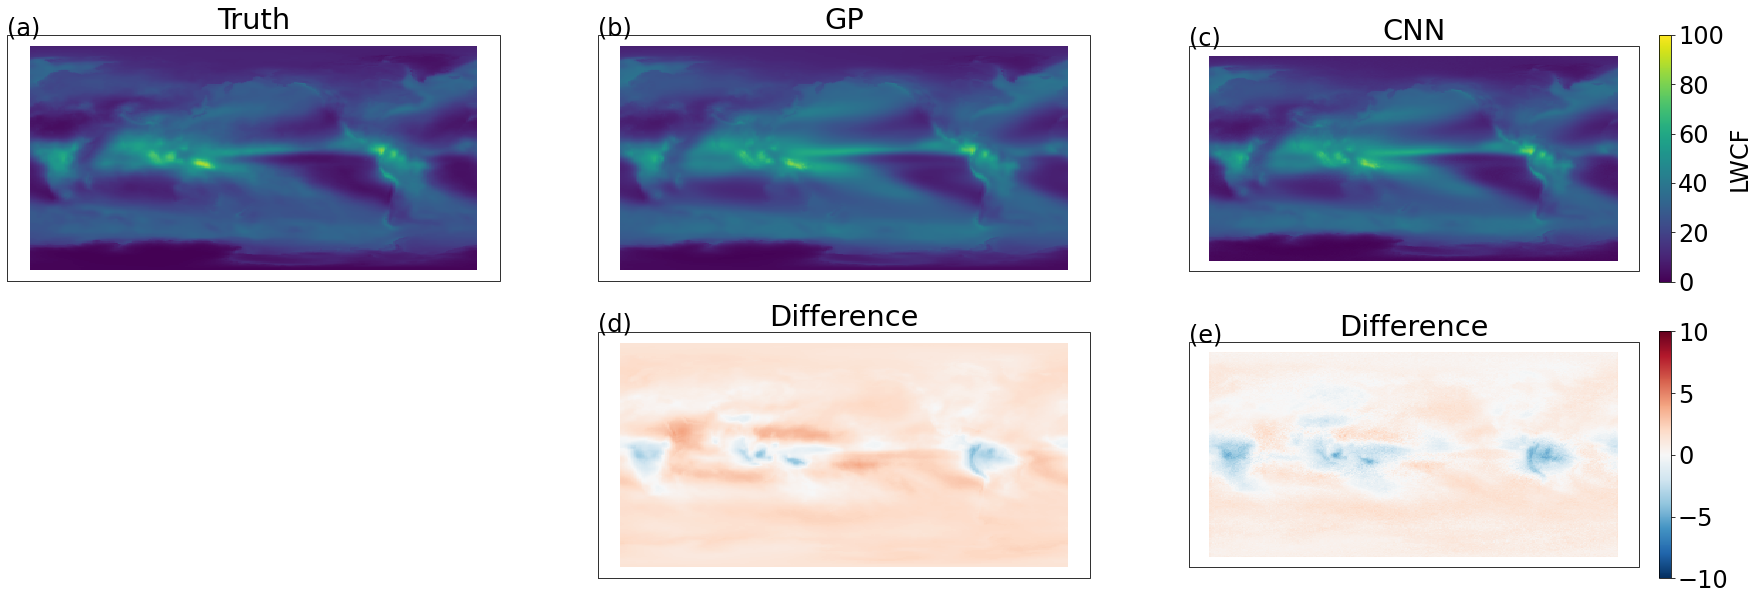

In [45]:
import matplotlib 
import cartopy.crs as ccrs
import iris.plot as iplt


plt.figure(figsize=(30, 10))
matplotlib.rcParams['font.size'] = 24

ma=350
mi=0
ma=100

plt.subplot(2,3,1, projection=ccrs.Mollweide())
plt.annotate("(a)", (0.,1.), xycoords='axes fraction')
#iplt.pcolormesh(imath.log10(Y_test[0]), vmin=-4, vmax=-1)
iplt.pcolormesh(Y_test[0], vmin=0, vmax=ma)
plt.gca().set_title('Truth')
plt.gca().coastlines()

plt.subplot(2,3,2, projection=ccrs.Mollweide())
plt.annotate("(b)", (0.,1.), xycoords='axes fraction')
#iplt.pcolormesh(imath.log10(gp_prediction[0]), vmin=-4, vmax=-1)
iplt.pcolormesh(gp_prediction[0], vmin=0, vmax=ma)
plt.gca().set_title('GP')
plt.gca().coastlines()

plt.subplot(2,3,3, projection=ccrs.Mollweide())
plt.annotate("(c)", (0.,1.), xycoords='axes fraction')
#im=iplt.pcolormesh(imath.log10(nn_prediction[0]), vmin=-4, vmax=-1)
im=iplt.pcolormesh(nn_prediction[0], vmin=0, vmax=ma)
plt.gca().set_title('CNN')
plt.colorbar(im, fraction=0.046, pad=0.04, label=output[0])
plt.gca().coastlines()

plt.subplot(2,3,5, projection=ccrs.Mollweide())
plt.annotate("(d)", (0.,1.), xycoords='axes fraction')
iplt.pcolormesh((gp_prediction.collapsed(['sample'], iris.analysis.MEAN)-Y_test.collapsed(['runs'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-10, vmax=10)
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.subplot(2,3,6, projection=ccrs.Mollweide())
plt.annotate("(e)", (0.,1.), xycoords='axes fraction')
im=iplt.pcolormesh((nn_prediction.collapsed(['sample'], iris.analysis.MEAN)-Y_test.collapsed(['runs'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-10, vmax=10)
cb = plt.colorbar(im, fraction=0.046, pad=0.04)
#cb.ax.set_yticklabels(["{:.2e}".format(i) for i in cb.get_ticks()]) ## set ticks of your format
plt.gca().coastlines()
plt.gca().set_title('Difference')

plt.savefig('emulator_'+typep+'_'+output[0]+'_.png', transparent=True)



86.0829779177296
86.0829779177296


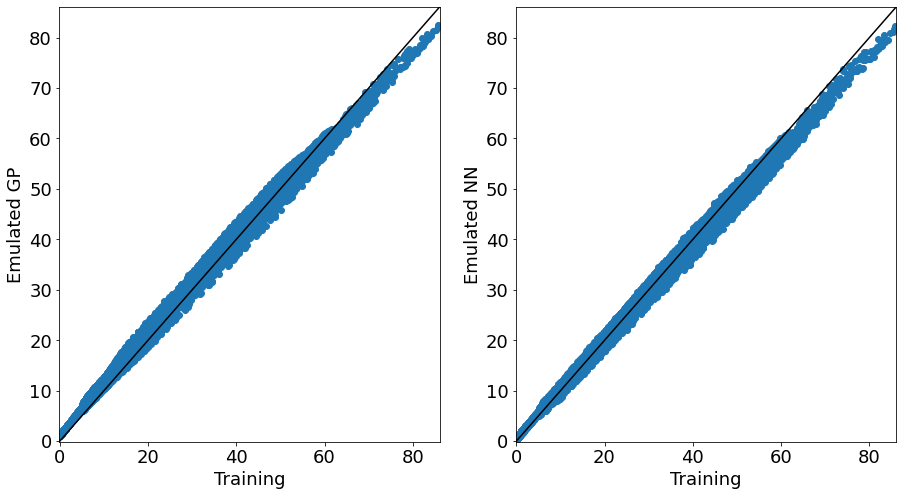

In [46]:
plt.figure(figsize=(15, 8))
matplotlib.rcParams['font.size'] = 18

plt.subplot(1,2,1)
plt.scatter(Y_test.collapsed(['runs'], iris.analysis.MEAN).data,(gp_prediction.collapsed(['sample'], iris.analysis.MEAN).data))
#plt.scatter(Y_test.collapsed(['runs'], iris.analysis.MEAN).data,(m.collapsed(['sample'], iris.analysis.MEAN).data))

plt.plot([-1e8,1e8],[-1e8,1e8],color='black')
#foo=xr.DataArray.from_iris(Y_test)  
foo=Y_test.collapsed(['runs'], iris.analysis.MEAN).data
print(foo.max())
plt.ylim(foo.min(),foo.max())
plt.xlim(foo.min(),foo.max())

plt.xlabel('Training')           
plt.ylabel('Emulated GP')

plt.subplot(1,2,2)
plt.scatter(Y_test.collapsed(['runs'], iris.analysis.MEAN).data,(nn_prediction.collapsed(['sample'], iris.analysis.MEAN).data))
#plt.scatter(Y_test.collapsed(['runs'], iris.analysis.MEAN).data,(m.collapsed(['sample'], iris.analysis.MEAN).data))

plt.plot([-1e8,1e8],[-1e8,1e8],color='black')
#foo=xr.DataArray.from_iris(Y_test)  
foo=Y_test.collapsed(['runs'], iris.analysis.MEAN).data
print(foo.max())
plt.ylim(foo.min(),foo.max())
plt.xlim(foo.min(),foo.max())

plt.xlabel('Training')           
plt.ylabel('Emulated NN')



#outdir='/glade/u/home/trude/work/NASA_graupel/PUMAS/PPE/oxford_emulator/plots/'
filename='scatter_emul_'+typep+'_'+str(output[o])+'.png'
plt.savefig(filename) 



In [47]:

#COLOR = 'white'
#matplotlib.rcParams['text.color'] = COLOR
#matplotlib.rcParams['axes.labelcolor'] = COLOR
#matplotlib.rcParams['xtick.color'] = COLOR
#matplotlib.rcParams['ytick.color'] = COLOR
#matplotlib.rcParams['font.size'] = 20

#plt.figure(figsize=(30, 10))

#plt.subplot(2,3,1, projection=ccrs.Mollweide())
#plt.annotate("(a)", (0.,1.), xycoords='axes fraction')
##iplt.pcolormesh(imath.log10(Y_test[0]), vmin=-4, vmax=-1)
#iplt.pcolormesh(Y_test[0], vmin=0, vmax=350)
#plt.gca().set_title('Truth')
#plt.gca().coastlines()

#plt.subplot(2,3,2, projection=ccrs.Mollweide())
#plt.annotate("(b)", (0.,1.), xycoords='axes fraction')
#iplt.pcolormesh(gp_prediction[0], vmin=0, vmax=350)
#plt.gca().set_title('GP')
#plt.gca().coastlines()

#plt.subplot(2,3,3, projection=ccrs.Mollweide())
#plt.annotate("(c)", (0.,1.), xycoords='axes fraction')
#im=iplt.pcolormesh(nn_prediction[0], vmin=0, vmax=350)
#plt.gca().set_title('CNN')
#plt.colorbar(im, fraction=0.046, pad=0.04, label=output[0])
#plt.gca().coastlines()

#plt.subplot(2,3,5, projection=ccrs.Mollweide())
#plt.annotate("(d)", (0.,1.), xycoords='axes fraction')
#iplt.pcolormesh((gp_prediction.collapsed(['sample'], iris.analysis.MEAN)-Y_test.collapsed(['runs'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-10, vmax=10)
#plt.gca().coastlines()
#plt.gca().set_title('Difference')

#plt.subplot(2,3,6, projection=ccrs.Mollweide())
#plt.annotate("(e)", (0.,1.), xycoords='axes fraction')
#im=iplt.pcolormesh((nn_prediction.collapsed(['sample'], iris.analysis.MEAN)-Y_test.collapsed(['runs'], iris.analysis.MEAN)), cmap='RdBu_r', vmin=-10, vmax=10)
#cb=plt.colorbar(im, fraction=0.046, pad=0.04)
#cb.ax.set_yticklabels(["{:.2e}".format(i) for i in cb.get_ticks()]) ## set ticks of your format
#plt.gca().coastlines()
#plt.gca().set_title('Difference')

#plt.savefig('BCPPE_emulator_talk.png', transparent=True)

In [48]:
print(ppe_outh)

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 60, runs: 251)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) datetime64[ns] 2000-01-16T12:00:00 ... 2004-12-14T12:00:00
  * runs     (runs) int64 0 1 2 3 4 5 6 7 8 ... 243 244 245 246 247 248 249 250
Data variables:
    LWCF     (runs, time, lat, lon) float32 ...
